# Convolutional Neural Networks
---
In this notebook, we train a **CNN** to classify spectrogram images of DPN+ and DPN- classes.

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

I have a 3000 core Nvdia Titan-X available in my workstation. Without GPU this code would take approximately 48 hours to complete. With GPU it takes about 45 minutes.

Since these are larger (129x27x3) images, it will prove useful to speed up training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
device = torch.device('cuda:1')

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
torch.cuda.get_device_name(1)

'GeForce GTX TITAN X'

---
## Load the Data

All spectrogram images are saved inside the 'data' foler. It has two subfolders, namely, "0" and "1". "0" folder contains images representing DPN- class while "1" foler represents DPN+ class.

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [4]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

### Define Transformations
Before loading the training and testing data some transformations are done on them. For all of the training, validation and test datasets, follwoing transformations are done:
* Resize 129x27 image to 128x32 images (for easier calculations of layer output)
* All images are normalized to have 0.5 mean and 0.5 standard deviation.
* Images are horizontally flipped with a probability of 0.5. This done to augment the dataset and strengthening the training, validation and testing.

In [5]:
# ### convert data to a normalized torch.FloatTensor
transforms = transforms.Compose([
    transforms.Resize((128, 32)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

### Splitting Dataset
Currently all images are inside the "data" folder. In the following section I split the image data into training, validation and testing groups maintaining a 70:15:15 proportion.

In [6]:
# choose the training and test datasets
# Loading datasets
data_dir = 'data'
trainPercent, valPercent, testPercent = 0.7, 0.15, 0.15 # has to equal to 1
all_data = datasets.ImageFolder(data_dir, transform=transforms)

# obtain training indices that will be used for validation
num_data = len(all_data)
indices = list(range(num_data))
np.random.shuffle(indices)

# Finding the splitting points
split1, split2 = int(np.floor(trainPercent * num_data)), int(np.floor((trainPercent+valPercent) * num_data))
train_idx, valid_idx, test_idx = indices[:split1], indices[split1:split2], indices[split2:]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(all_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(all_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(all_data, batch_size=batch_size, 
    sampler=test_sampler, num_workers=num_workers)

In [7]:
# specify the image classes
classes = ['DPN-', 'DPN+']

### Visualize a Batch of Training Data

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

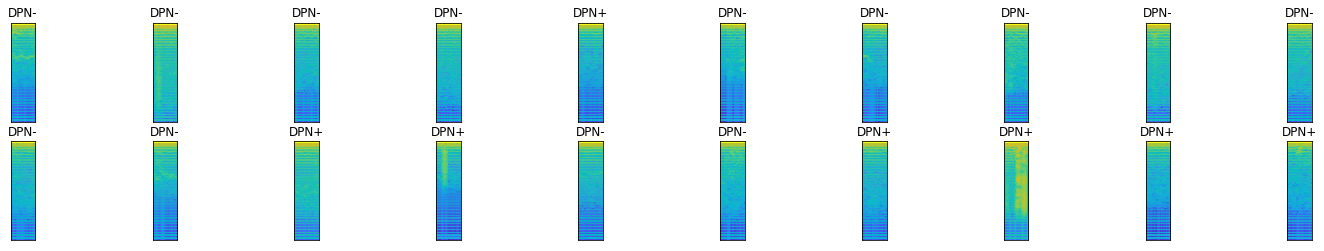

In [9]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

In [10]:
# rgb_img = np.squeeze(images[3])
# channels = ['red channel', 'green channel', 'blue channel']

# fig = plt.figure(figsize = (36, 36)) 
# for idx in np.arange(rgb_img.shape[0]):
#     ax = fig.add_subplot(1, 3, idx + 1)
#     img = rgb_img[idx]
#     ax.imshow(img, cmap='gray')
#     ax.set_title(channels[idx])
#     width, height = img.shape
#     thresh = img.max()/2.5
#     for x in range(width):
#         for y in range(height):
#             val = round(img[x][y],2) if img[x][y] !=0 else 0
#             ax.annotate(str(val), xy=(y,x),
#                     horizontalalignment='center',
#                     verticalalignment='center', size=8,
#                     color='white' if img[x][y]<thresh else 'black')

---
## Defining the Network [Architecture](http://pytorch.org/docs/stable/nn.html)


#### Output volume for a convolutional layer
To compute the output size of a given convolutional layer we can perform the following calculation (taken from [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`. 

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

In [11]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 128x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) 
        # convolutional layer (sees 64x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) 
        # convolutional layer (sees 32x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) 
        # convolutional layer (sees 16x4x64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # convolutional layer (sees 8x2x128 tensor)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        # output: 4*1*256
        
        # batch normalization layers after each Conv layer
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(256)
        
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (4*1*256 -> 512)
        self.fc1 = nn.Linear(4*1*256, 512)
        # linear layer (512 -> 256)
        self.fc2 = nn.Linear(512, 256)
        # linear layer (256 -> 2)
        self.fc3 = nn.Linear(256, 2)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        # flatten image input
        x = x.view(-1, 4*1*256)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add 3nd hidden layer without relu
        x = self.fc3(x)
        
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Line

### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

I chose Cross-Entropy Loss as loss function and Stochastic Gradient Descent as my optimizer for this problem.  
I set the learning rate to 0.01.

In [12]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

---
## Train the Network

Training the model with 300 epochs.  
While training the model weights will be saved whenever the validation loss decreases. In this way, after the training is done, we will have the best model saved.

### Learning Rate Stepping
For this model learning rate is started with 0.01. And every 100 epochos it is scaled by 0.1.

In [13]:
# Setting up learning rate decay
from torch.optim import lr_scheduler
lr_step_size = 100
scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=0.1)

# number of epochs to train the model
n_epochs = 300 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    scheduler.step()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # print Learning rate change
    if epoch%lr_step_size == 1:
        for param_group in optimizer.param_groups:
            print('LR: {}' .format(param_group['lr']) )
            break    
            
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_2.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.479191 	Validation Loss: 0.099402
LR: 0.01
Validation loss decreased (inf --> 0.099402).  Saving model ...
Epoch: 2 	Training Loss: 0.467197 	Validation Loss: 0.098743
Validation loss decreased (0.099402 --> 0.098743).  Saving model ...
Epoch: 3 	Training Loss: 0.459548 	Validation Loss: 0.096946
Validation loss decreased (0.098743 --> 0.096946).  Saving model ...
Epoch: 4 	Training Loss: 0.451014 	Validation Loss: 0.094277
Validation loss decreased (0.096946 --> 0.094277).  Saving model ...
Epoch: 5 	Training Loss: 0.441451 	Validation Loss: 0.093905
Validation loss decreased (0.094277 --> 0.093905).  Saving model ...
Epoch: 6 	Training Loss: 0.430764 	Validation Loss: 0.091610
Validation loss decreased (0.093905 --> 0.091610).  Saving model ...
Epoch: 7 	Training Loss: 0.421895 	Validation Loss: 0.088242
Validation loss decreased (0.091610 --> 0.088242).  Saving model ...
Epoch: 8 	Training Loss: 0.409978 	Validation Loss: 0.084896
Validation loss decreased

Epoch: 108 	Training Loss: 0.011254 	Validation Loss: 0.100344
Epoch: 109 	Training Loss: 0.008863 	Validation Loss: 0.097917
Epoch: 110 	Training Loss: 0.009307 	Validation Loss: 0.100042
Epoch: 111 	Training Loss: 0.008615 	Validation Loss: 0.103255
Epoch: 112 	Training Loss: 0.007367 	Validation Loss: 0.108376
Epoch: 113 	Training Loss: 0.008389 	Validation Loss: 0.109667
Epoch: 114 	Training Loss: 0.008394 	Validation Loss: 0.111234
Epoch: 115 	Training Loss: 0.006703 	Validation Loss: 0.110828
Epoch: 116 	Training Loss: 0.008007 	Validation Loss: 0.111462
Epoch: 117 	Training Loss: 0.007643 	Validation Loss: 0.111420
Epoch: 118 	Training Loss: 0.006880 	Validation Loss: 0.112271
Epoch: 119 	Training Loss: 0.005839 	Validation Loss: 0.116075
Epoch: 120 	Training Loss: 0.006820 	Validation Loss: 0.116669
Epoch: 121 	Training Loss: 0.006475 	Validation Loss: 0.113596
Epoch: 122 	Training Loss: 0.005723 	Validation Loss: 0.118894
Epoch: 123 	Training Loss: 0.004864 	Validation Loss: 0

Epoch: 238 	Training Loss: 0.002228 	Validation Loss: 0.147645
Epoch: 239 	Training Loss: 0.002041 	Validation Loss: 0.153697
Epoch: 240 	Training Loss: 0.001940 	Validation Loss: 0.154061
Epoch: 241 	Training Loss: 0.002920 	Validation Loss: 0.143735
Epoch: 242 	Training Loss: 0.001706 	Validation Loss: 0.148060
Epoch: 243 	Training Loss: 0.001406 	Validation Loss: 0.148487
Epoch: 244 	Training Loss: 0.001996 	Validation Loss: 0.143118
Epoch: 245 	Training Loss: 0.002091 	Validation Loss: 0.147595
Epoch: 246 	Training Loss: 0.002184 	Validation Loss: 0.151928
Epoch: 247 	Training Loss: 0.001822 	Validation Loss: 0.147802
Epoch: 248 	Training Loss: 0.001364 	Validation Loss: 0.150551
Epoch: 249 	Training Loss: 0.001946 	Validation Loss: 0.148779
Epoch: 250 	Training Loss: 0.001774 	Validation Loss: 0.151494
Epoch: 251 	Training Loss: 0.001667 	Validation Loss: 0.146358
Epoch: 252 	Training Loss: 0.001994 	Validation Loss: 0.149013
Epoch: 253 	Training Loss: 0.002277 	Validation Loss: 0

###  Load the Model with the Lowest Validation Loss

In [14]:
model.load_state_dict(torch.load('model_2.pt'))

---
## Test the Trained Network

Testing trained model on previously unseen data! The model with the lowest validation loss is selected.

In [15]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.044161

Test Accuracy of  DPN-: 88% (1695/1922)
Test Accuracy of  DPN+: 85% (1551/1818)

Test Accuracy (Overall): 86% (3246/3740)


### Visualize Sample Test Results

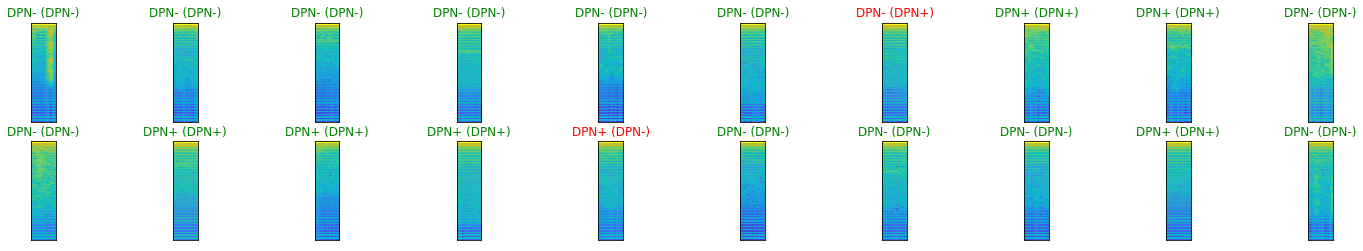

In [16]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.to(device)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))